In [99]:
import os
import numpy as np
import scipy as sp
from scipy import signal
import random

In [100]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Comparing correlation of envelopes vs envelope of correlations

For the purpose of determining the time shift of one station with respect to another, this notebook empirically examines whether we get better results by

1. correlating the mean envelope with the envelope for a given interval; OR
2. enveloping the correlation of the mean correlation with an interval's correlation.

Reference paper Hable _et al._ (2018) computes the clock errors using method 2., but GA code uses 1.

15 7


<StemContainer object of 3 artists>

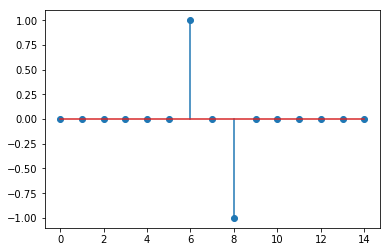

In [101]:
# Generate a primitive pulse in the form of a zero mean impulse, sampled at the Nyqvist frequency
pulse = np.array([0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0])
N = len(pulse)
wasteN = int((N - 1.0)/2)
print(N, wasteN)
plt.stem(pulse)

In [102]:
def randomSignal(base_signal, signal_order=1, amplitude=1.0, noise_order=1):
    """
    Given a base signal, generate a new signal with static component
    derived from base_signal (signal_order convolutions of it) with
    additive noise consisting of noise_order phase shifts of base_signal.
    """
    L = len(base_signal)
    start = int((L-1.0)/2)
    b0 = base_signal
    for i in range(signal_order-1):
        b0 = np.convolve(b0, base_signal)
        b0 = b0[start:start + L]
    b0 = b0/np.max(np.abs(b0))
    signal = b0
    for i in range(noise_order):
        noise = np.roll(base_signal, random.randint(0, L - 1))
        signal = signal + amplitude*noise*np.sign(random.random() - 0.5)
    return signal

In [103]:
def envelope(signal):
    """Envelope the input signal"""
    return np.abs(sp.signal.hilbert(signal))

In [136]:
random.seed(20190218)
# The number of random signal correlations to create. Make sure S is a multiple of 100 for subsequent plotting.
S = 1000
# Collection of the S xcorr's
interval_xcorr = []
# Arrays in which to accumulate the cross correlations and their envelopes
sum_of_correlations = np.zeros(2 * N - 1)
sum_of_envelopes = np.zeros(2 * N - 1)
# Index at which to introduce timing error
error_start = int(0.7*S)
# Magnitude of timing error in samples
timing_error = int(5)
# Parameters of the synthesized signal
signal_order = 1
noise_amplitude = 0.2
# Generate CCFs
for i in range(S):
    sigA = randomSignal(pulse, amplitude=noise_amplitude, noise_order=5, signal_order=signal_order)
    sigB = randomSignal(pulse, amplitude=noise_amplitude, noise_order=5, signal_order=signal_order)
    if i >= error_start:
        sigB = np.roll(sigB, timing_error)
    xcorr = np.convolve(sigA, sigB)
    interval_xcorr.append(xcorr)
    sum_of_correlations += xcorr
    env = envelope(xcorr)
    sum_of_envelopes += env

# Normalize by sample count to get the mean
sum_of_correlations = sum_of_correlations/S
sum_of_envelopes = sum_of_envelopes/S
# Compute the envelope of the mean xcorr
envelope_of_sums = envelope(sum_of_correlations)

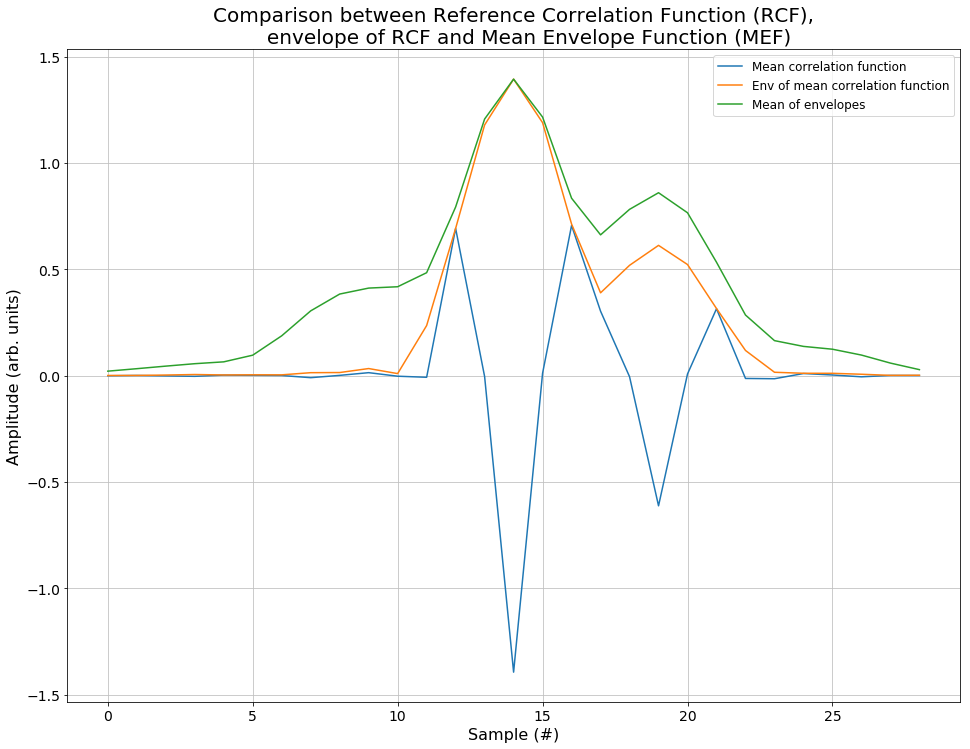

In [137]:
plt.figure(figsize=(16,12))
plt.plot(sum_of_correlations)
plt.plot(envelope_of_sums)
plt.plot(sum_of_envelopes*np.max(envelope_of_sums)/np.max(sum_of_envelopes))
plt.legend(['Mean correlation function', 'Env of mean correlation function', 'Mean of envelopes'], fontsize=12)
plt.grid(color="#c0c0c080")
plt.xlabel("Sample (#)", fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel("Amplitude (arb. units)", fontsize=16)
plt.yticks(fontsize=14)
plt.title("Comparison between Reference Correlation Function (RCF),\n \
    envelope of RCF and Mean Envelope Function (MEF)", fontsize=20)
None

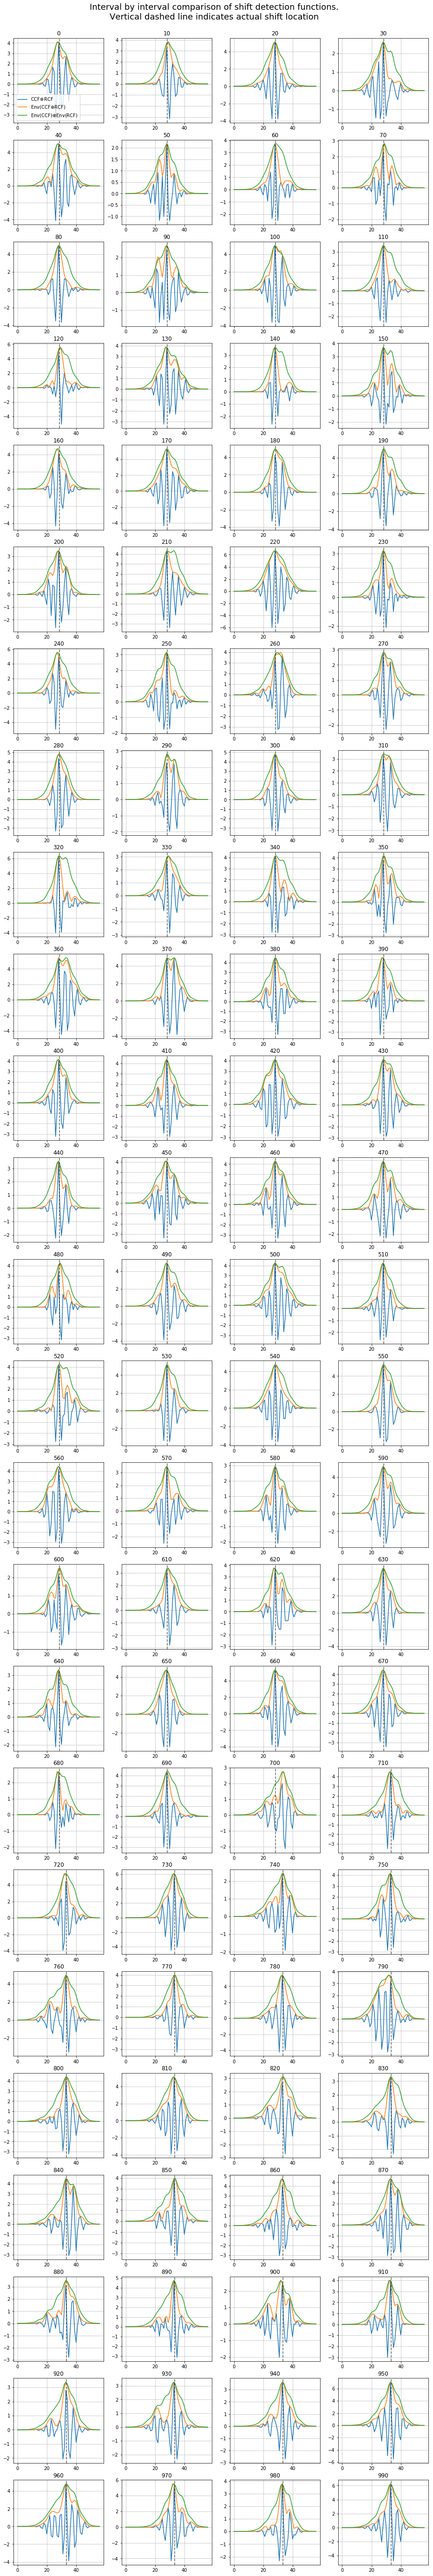

In [138]:
# For each CCF, plot its cross correlation with RCF, the envelope of CCF*RCF, 
# and the cross correlation of the envelope of CCF with the envelope of RCF.
num_rows = 25
num_cols = 4
subplot_size = (num_rows, num_cols)
plt.subplots(subplot_size[0], subplot_size[1], figsize=(16, 16*subplot_size[0]/subplot_size[1]))
plot_index = int(0)
plot_stride = int(S/num_rows/num_cols)
i = 0
for r in range(subplot_size[0]):
    for _ in range(subplot_size[1]):
        c = interval_xcorr[plot_index]
        plt.subplot(subplot_size[0], subplot_size[1], i + 1)
        cf_xcorr = np.convolve(c, sum_of_correlations)
        cf_xcorr_env = envelope(cf_xcorr)
        c_env = envelope(c)
        xcorr_c_env = np.convolve(c_env, sum_of_envelopes)
        xcorr_c_env = xcorr_c_env*max(cf_xcorr_env)/max(xcorr_c_env)
        plt.plot(cf_xcorr)
        plt.plot(cf_xcorr_env)
        plt.plot(xcorr_c_env)
        plt.title(str(plot_index))
        if plot_index == 0:
            plt.legend(['CCF$\otimes$RCF', 'Env(CCF$\otimes$RCF)', 'Env(CCF)$\otimes$Env(RCF)'])
        datalen = len(cf_xcorr)
        if plot_index > error_start:
            plt.axvline(x=(datalen/2 + timing_error), color='k', linestyle='--', alpha=0.6)
        else:
            plt.axvline(x=(datalen/2), color='k', linestyle='--', alpha=0.6)
        plt.grid(color="#c0c0c080")
        plt.suptitle("Interval by interval comparison of shift detection functions.\n"
                     "Vertical dashed line indicates actual shift location",
                     fontsize=18, va='bottom', y=.885)
        plot_index += plot_stride
        i += 1

## Summary

Visual review of the above array of plots shows that although the orange Env(CCF$\otimes$RCF) peaks are sharper, they are also less accurate locating the true shift compared to the green Env(CCF)$\otimes$Env(RCF) peaks. This validates the GA approach of using the latter to locate clock shifts in preference to the method of Hable _et al._ This seems to hold true across a range of values of signal_order and noise_amplitude.